### Cartographer Pre-processing

The goal of `cartographer` is to density modify isomorphous difference maps using variational inference. 
The inputs for `cartographer` are 
 - `Foff:` ground state structure factors
 - `SigFoff:` ground state structure factor uncertainty
 - `PhiFoff:` refined ground state phases
 - `Fon:` perturbed structure factors
 - `SigFon:` perturbed structure factor uncertainties

The entry point for `cartographer` makes some pretty stringent assumptions about how these data have been prepared. 
Firstly, they should be in a single mtz file.
The ground state structure factors need to be on a reasonable scale such that the fourier transform is a reasonable proxy for electron density. 
The easiest way to do this is to use the output from `phenix.refine`. 
Particularly, the `F-obs-filtered` and `SIGF-obs-filtered` are good choices. 
The perturbed structure factors, `Fon` and uncertainties `SigFon` should be placed on the same scale as these ground state structure factors. 
In this notebook, we will accomplish that using the `mean_intensity_by_resolution` function from `rs.algorithms.scale_merged_intensities`.


Foff   SigFoff       Fon      SigFon      PhiFoff  M/ISYM
H  K  L                                                                
1  1  1   525.3065  8.383242 478.33127  0.18014266   0.36354065       1
      2  201.89886  5.401754   196.619   0.1201069  -0.39389038       1
      3  223.42572  5.562935 196.24759  0.10454317  -0.09152222       1
      4  283.11682 6.0144153  288.4064 0.123533145 -0.026916504       1
      5   181.7573   5.32033 188.62865  0.10322511   0.80485535       1
...            ...       ...       ...         ...          ...     ...
30 11 11 17.115528  11.68451  16.03926  0.18381506   0.49642944       1
      12 18.013727 12.080936  18.23881  0.19866964   0.11276245       1
   12 1  16.531048 10.614634 14.169309  0.18821427    0.5128784       1
      2  12.395851  8.357143  25.98669  0.26395115   -0.3479309       1
      3  15.806089 10.010892  16.98865  0.21539606 -0.016204834       1

[58433 rows x 6 columns]

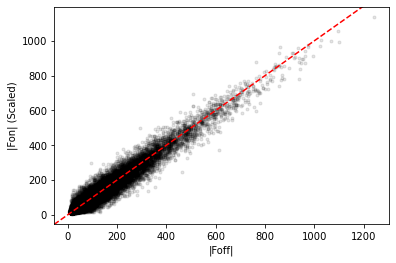

In [6]:
from reciprocalspaceship.algorithms.scale_merged_intensities import mean_intensity_by_resolution
import reciprocalspaceship as rs
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np


reference_file = "dhfr/folate/refine.mtz"
unscaled_file = "dhfr/methotrexate/merged.mtz"
outFN = 'dhfr.mtz'

reference = rs.read_mtz(reference_file).dropna()
unscaled  = rs.read_mtz(unscaled_file).dropna()

refkey = 'F-obs-filtered'
phase_key = 'PHIF-model'
key = 'I'
sig = 'SIG'



def scale_like(unscaled, sig_unscaled, reference, dHKL, bins=50, gridpoints=None):
    """ 
    Put one set of structure factors or intensities on the same scale as another. 

    Parameters
    ----------
    unscaled : array
        unscaled structure factors or intensities
    sig_unscaled : array
        uncertainty of unscaled
    reference : array
        structure factors or intenties on the relevant scale
    dHKL : array
        the resolution of each reflection in unscaled/scaled

    Returns
    -------
    scaled : array
        reflections on the same scale as `reference`
    sig_scaled : array
        uncertainties on the same scale as `reference`
    """
    unscaled = np.array(unscaled, dtype=np.float)
    sig_unscaled = np.array(sig_unscaled, dtype=np.float)
    reference = np.array(reference, dtype=np.float)
    dHKL = np.array(dHKL, dtype=np.float)

    Sigma = mean_intensity_by_resolution(unscaled, dHKL, bins, gridpoints)
    Sigma_ref = mean_intensity_by_resolution(reference, dHKL, bins, gridpoints)
    scaled = unscaled * Sigma_ref / Sigma 
    sig_scaled = sig_unscaled * Sigma_ref / Sigma 
    return scaled, sig_unscaled



def friedel_keys(base):
    return [
        base + "(+)",
        base + "(-)",
    ]

def friedel_fsigf_keys(base, sig = 'SIG'):
    return friedel_keys(base) + [
        sig + base + "(+)",
        sig + base + "(-)",
    ]

reference = reference[friedel_fsigf_keys(refkey) + friedel_keys(phase_key)]
unscaled = unscaled[friedel_fsigf_keys(key)]
reference[phase_key] = np.mean(reference[[phase_key + "(+)", phase_key + "(-)"]], axis=1)

idx = unscaled.index.intersection(reference.index)
reference = reference.loc[idx]
unscaled  = unscaled.loc[idx]

#This block will add the mean intensity/sigma for friedel mates
F = np.nansum(reference[friedel_keys(refkey)], axis=1)/2.
SigF = np.sqrt(np.nansum(reference[friedel_keys(sig + refkey)]**2., axis=1).astype(float))

reference['F'] = rs.DataSeries(F, dtype='F', index=reference.index)
reference['SIGF'] = rs.DataSeries(SigF, dtype='Q', index=reference.index)

I = np.nansum(unscaled[friedel_keys(key)], axis=1)/2.
SigI = np.sqrt(np.nansum(unscaled[friedel_keys(sig + key)]**2., axis=1).astype(float))

unscaled['I'] = rs.DataSeries(I, dtype='J', index=unscaled.index)
unscaled['SIGI'] = rs.DataSeries(SigI, dtype='Q', index=unscaled.index)

ds = rs.DataSet({
    'Fref': reference['F'],
    'SIGFref': reference['SIGF'],
    'I': unscaled['I'],
    'SIGI': unscaled['SIGI'],
    phase_key : reference[phase_key],
}, cell=reference.cell, spacegroup=reference.spacegroup).dropna()


ds = rs.algorithms.scale_merged_intensities(ds, 'I', 'SIGI', dropna=False)
F,SigF = scale_like(ds['FW-F'], ds['FW-SIGF'], ds['Fref'], ds['dHKL'])



result = rs.DataSet({
    'Foff': ds['Fref'],
    'SigFoff': ds['SIGFref'],
    'Fon': F,
    'SigFon': SigF,
    'PhiFoff' : ds[phase_key]
}).astype({
    'Foff': 'F',
    'SigFoff': 'Q',
    'Fon': 'F',
    'SigFon': 'Q',
    'PhiFoff' : 'P',
})
result.cell = reference.cell
result.spacegroup = reference.spacegroup

#Quick sanity check on the scale
plt.figure()
plt.plot(result.Foff, result.Fon, 'k.', alpha=0.1)
plt.xlabel("|Foff|")
plt.ylabel("|Fon| (Scaled)")
plt.plot(plt.xlim(), plt.xlim(), '--r', scalex=False, scaley=False)



result.write_mtz(outFN)
result
